## 0. Importing libraries and raw data

In [141]:
#Libraries for data manipulation
import pandas as pd
import re
import datetime as dt

#Library for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Libraries for generating the word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [142]:
#Reading txt file as text
file_path = r'/Users/gtbandara/Documents/Python/Misc Inputs/WhatsApp/Probabilistic Intel Chat.txt' 

with open(file_path, "r") as file:
    file_contents = file.read()

print(file_contents)

[01/05/2020, 15:59:52] Probabilistic Intel 🦄: ‎Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them.
[01/05/2020, 15:59:52] Pasindu Stax: ‎Pasindu Stax created this group
[10/12/2020, 14:13:09] Probabilistic Intel 🦄: ‎Pasindu Stax added you
[10/12/2020, 14:14:05] Pasindu Stax: Welcome to the analytics memes and fun stuff, gentlemen.
[10/12/2020, 14:21:15] Menan Stax: Hi
[10/12/2020, 14:21:17] Menan Stax: Thanx
[10/12/2020, 14:23:53] Menan Stax: ‎This message was deleted.
[10/12/2020, 14:25:36] Pasindu Stax: 😂 @94724197291  you got real competition now.
[10/12/2020, 14:29:34] Menan Stax: Sorry it was screenshot ill fix it
‎[10/12/2020, 14:32:24] Menan Stax: ‎image omitted
[10/12/2020, 14:35:45] Shane Stax: That's our musky
[10/12/2020, 14:38:58] Pasindu Stax: https://www.google.com/amp/s/www.nbcnews.com/news/amp/ncna1250333

Talking about space man. Did you see this?
[10/12/2020, 14:42:58] Menan Stax: Hahhahahhaha or his

## 1. Preparation of file for analysis

In [143]:
#End goal is to have a dataframe with the columns date, time, participant and message

### 1.1. Initial dataframe cleaning 

In [144]:
#Splitting each new line and converting to list
file_contents = file_contents.split('\n').copy()

#Converting to dataframe
df = pd.DataFrame(file_contents)
df

,0
0,"[01/05/2020, 15:59:52] Probabilistic Intel 🦄: ..."
1,"[01/05/2020, 15:59:52] Pasindu Stax: ‎Pasindu ..."
2,"[10/12/2020, 14:13:09] Probabilistic Intel 🦄: ..."
3,"[10/12/2020, 14:14:05] Pasindu Stax: Welcome t..."
4,"[10/12/2020, 14:21:15] Menan Stax: Hi"
...,...
7705,"[24/01/2024, 21:43:53] ~ Randika: Api karana A..."
7706,"[28/01/2024, 20:29:54] ~ P@ndula: https://cybe..."
7707,"[12/02/2024, 04:25:25] ~ Mano Senaratne: https..."
7708,"[12/02/2024, 04:25:47] ~ Mano Senaratne: 80's ..."


In [145]:
#Renaming column
df.rename(columns={0:'Text'},inplace=True)

#Removing blank rows
df = df[df['Text']!=''].copy()

#Removing standard WhatsApp messages
df = df[~(df['Text'].str.contains(' was added') | df['Text'].str.contains('changed the group name') | df['Text'].str.contains('calls are end-to-end encrypted') | df['Text'].str.contains(' omitted'))].reset_index(drop=True).copy()


### 1.2. Parsing text into columns

In [146]:
#Defining function to parse text
def extract_timestamp(column,text):

    #Defining patterns
    patterns = {'Timestamp':'\[([^\]]+)\] ',
                'Participant':'\]\s*(.*?):',
                'Message':'\d{2}:\d{2}:\d{2}\] .*?:\s*(.*)$'}

    match = re.search(patterns.get(column), text)
    if match:
        return match.group(1)
    elif column == 'Message':
        return text
    else:
        return ''

#Applying function to create relevant columns
df['Timestamp'] = df['Text'].apply(lambda x: extract_timestamp('Timestamp',x))
df['Participant'] = df['Text'].apply(lambda x: extract_timestamp('Participant',x))
df['Message'] = df['Text'].apply(lambda x: extract_timestamp('Message',x))
df

,Text,Timestamp,Participant,Message
0,"[01/05/2020, 15:59:52] Pasindu Stax: ‎Pasindu ...","01/05/2020, 15:59:52",Pasindu Stax,‎Pasindu Stax created this group
1,"[10/12/2020, 14:13:09] Probabilistic Intel 🦄: ...","10/12/2020, 14:13:09",Probabilistic Intel 🦄,‎Pasindu Stax added you
2,"[10/12/2020, 14:14:05] Pasindu Stax: Welcome t...","10/12/2020, 14:14:05",Pasindu Stax,"Welcome to the analytics memes and fun stuff, ..."
3,"[10/12/2020, 14:21:15] Menan Stax: Hi","10/12/2020, 14:21:15",Menan Stax,Hi
4,"[10/12/2020, 14:21:17] Menan Stax: Thanx","10/12/2020, 14:21:17",Menan Stax,Thanx
...,...,...,...,...
6605,"[24/01/2024, 21:43:44] ~ Randika: Haha","24/01/2024, 21:43:44",~ Randika,Haha
6606,"[24/01/2024, 21:43:53] ~ Randika: Api karana A...","24/01/2024, 21:43:53",~ Randika,Api karana AI wage
6607,"[28/01/2024, 20:29:54] ~ P@ndula: https://cybe...","28/01/2024, 20:29:54",~ P@ndula,https://cybernews.com/security/billions-passwo...
6608,"[12/02/2024, 04:25:25] ~ Mano Senaratne: https...","12/02/2024, 04:25:25",~ Mano Senaratne,https://youtu.be/PE1lzqJCeJ0?feature=shared


### 1.3. Exclusion of invalid rows

In [147]:
#Finding group name
try:
    grp_name = re.search('“([^“”]+)”',df.loc[0,'Message']).group(1)

    #Excluding rows with Participant as group name
    exceptions_df = df[df['Participant']==grp_name].reset_index(drop=True)
    exceptions_df['Flag'] = 'Rows automatically created by WhatsApp'

    df = df[df['Participant']!=grp_name].reset_index(drop=True)
except:
    exceptions_df = pd.DataFrame()

In [148]:
#Excluding rows with Participant as WhatsApp
exc = df[df['Participant'].str.contains('WhatsApp')]
exc['Flag'] = 'Invalid rows'
exceptions_df = pd.concat([exceptions_df,exc],ignore_index=True)

df = df[~df['Participant'].str.contains('WhatsApp')].reset_index(drop=True)

In [149]:
#Excluding invalid rows based on Timestamp length. These are due to forwarded messages
df['Len'] = df['Timestamp'].apply(lambda x: len(x.split(',')[0]))

exc = df[df['Len']==5]
exc['Flag'] = 'Forwarded messages'
exceptions_df = pd.concat([exceptions_df,exc],ignore_index=True)

df = df[df['Len']!=5].reset_index(drop=True)

#Dropping temporary len column
df.drop(columns='Len',inplace=True)
exceptions_df.drop(columns='Len',inplace=True)

### 1.4. Final cleaning of dataframe

In [150]:
#Removing whitespace from timestamp column
df['Timestamp'] = df['Timestamp'].str.strip()

#Creating date and time columns from timestamp
df.loc[:,['Date','Time']] = df['Timestamp'].str.split(',',expand=True).rename(columns={0:'Date',1:'Time'})

#Rearranging columns and dropping timestamp
df = df[['Text','Participant','Date','Time','Message']]

#Reassigning blank values in Participant, Date and Time columns as None
df.loc[df['Date']=='',['Participant','Date','Time']] = None

#Forwarding filling none columns
df.loc[:,['Participant','Date','Time']] = df.loc[:,['Participant','Date','Time']].ffill()

In [151]:
#Converting date and time columns into pandas date/time, and then a timestamp column
df['Date'] = pd.to_datetime(df['Date'].str.strip(),format='%d/%m/%Y')
df['Time'] = pd.to_datetime(df['Time'].str.strip(), format='%H:%M:%S').dt.time
df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

### 1.5. Transforming dataframe to concatenate messages

In [152]:
#Concatenating messages after grouping by timestamp and participant
final_df = df.groupby(['Timestamp','Participant'])['Message'].agg(lambda x: ', '.join(x)).reset_index()

In [153]:
#Creating date descriptors from timestamp column
final_df['Date'] = final_df['Timestamp'].dt.date
final_df['Month-year'] = final_df['Timestamp'].dt.strftime("%B %Y")
final_df['Day of Week'] = final_df['Timestamp'].dt.day_name()

## 2. Analysis

### 2.1. Sentiment analysis

In [154]:
#Creating VADER sentiment analysis classification
analyzer = SentimentIntensityAnalyzer()

#Creating function to get sentiment scores
def get_sentiment_score(sentence):
    score = analyzer.polarity_scores(sentence)['compound']
    if score<-0.05:
        return 'Negative'
    elif score>0.05:
        return 'Positive'
    else:
        return 'Neutral'

#Applying sentiment analysis classification to the Message column
final_df['Sentiment'] = final_df['Message'].apply(get_sentiment_score)
final_df

,Timestamp,Participant,Message,Date,Month-year,Day of Week,Sentiment
0,2020-05-01 15:59:52,Pasindu Stax,‎Pasindu Stax created this group,2020-05-01,May 2020,Friday,Positive
1,2020-05-01 15:59:52,Probabilistic Intel 🦄,‎You were added,2020-05-01,May 2020,Friday,Neutral
2,2020-12-10 14:13:09,Probabilistic Intel 🦄,‎Pasindu Stax added you,2020-12-10,December 2020,Thursday,Neutral
3,2020-12-10 14:14:05,Pasindu Stax,"Welcome to the analytics memes and fun stuff, ...",2020-12-10,December 2020,Thursday,Positive
4,2020-12-10 14:21:15,Menan Stax,Hi,2020-12-10,December 2020,Thursday,Neutral
...,...,...,...,...,...,...,...
6306,2024-01-24 21:43:44,~ Randika,Haha,2024-01-24,January 2024,Wednesday,Positive
6307,2024-01-24 21:43:53,~ Randika,Api karana AI wage,2024-01-24,January 2024,Wednesday,Neutral
6308,2024-01-28 20:29:54,~ P@ndula,https://cybernews.com/security/billions-passwo...,2024-01-28,January 2024,Sunday,Neutral
6309,2024-02-12 04:25:25,~ Mano Senaratne,https://youtu.be/PE1lzqJCeJ0?feature=shared,2024-02-12,February 2024,Monday,Neutral


In [155]:
exceptions_df

,Text,Timestamp,Participant,Message,Flag


### 2.2. Generating a Word Cloud

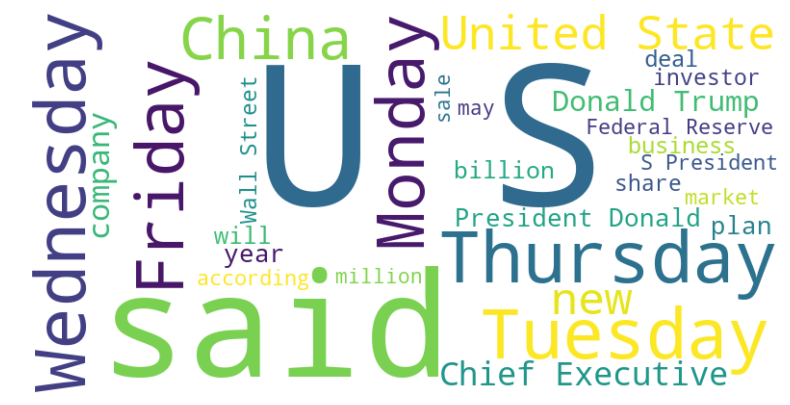

In [140]:
#Concatenating all text into a single string
text = ' '.join(final_df['Message'])

#Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',max_words=30).generate(text)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()